In [40]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

from equationmodel_gp import gp_regression, prediction_rmse_error, gp_train_graph, gp_linear_compare_graph
from equationmodel_ann import ann_mlp_regression, prediction_rmse_error, ann_linear_compare_graph
from util import ADD_data_loader, combineDF, filteringDF, getFreeSpacePathLoss, makeXforGraphWithGroupingFrequency,\
                makeXforGraph, inverseScale, samplingData, normalizeData,train_2d_graph, train_3d_graph, makeXforGraphWithGroupingSeason, train_2d_sigma_graph

desired_width=620
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',30)
pd.options.display.float_format = "{:.2f}".format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ADD data preprocessing
../data/PLdata_paju_sp_2249.csv: distance filtering(before):(90428, 4)
../data/PLdata_paju_sp_2249.csv: distance filtering(after):(9372, 4)
../data/PLdata_paju_sp_1399.csv: distance filtering(before):(90501, 4)
../data/PLdata_paju_sp_1399.csv: distance filtering(after):(9372, 4)
../data/PLdata_paju_sp_400.csv: distance filtering(before):(90557, 4)
../data/PLdata_paju_sp_400.csv: distance filtering(after):(9372, 4)
         type  distance  pathloss  heightTM  season  frequency  heightTB  heightB  heightM
type 271    m      1.00     99.19      0.02       1       2249        30       15        2
     272    m      1.00     99.52      0.02       1       2249        30       15        2
     273    m      1.00    100.38      0.02       1       2249        30       15        2
     274    m      1.00    102.94      0.02       1       2249        30       15        2
     275    m      1.00    114.93      0.02       1       2249        30       15        2
Combined data

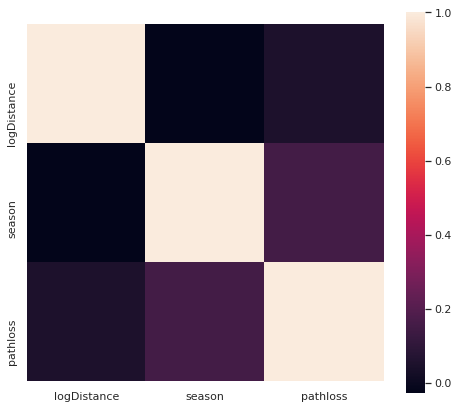

In [36]:
%autoreload

iksan_fileList = {'../data/PLdata_paju_sp_400.csv':[('season', 1),('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_paju_sp_1399.csv':[('season', 1),('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_paju_sp_2249.csv':[('season', 1),('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
nonsan_fileList = {'../data/PLdata_paju_sm_400.csv':[('season', 2),('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_paju_sm_1399.csv':[('season', 2),('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_paju_sm_2249.csv':[('season', 2),('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
paju_fileList = {'../data/PLdata_paju_wt_400.csv':[('season', 0),('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_1399.csv':[('season', 0),('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_2249.csv':[('season', 0),('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}

addIksan = ADD_data_loader(iksan_fileList)
print("Iksan data:",addIksan.shape)
print("")
addNonsan = ADD_data_loader(nonsan_fileList)
print("Nonsan data:",addNonsan.shape)
print("")
addPaju = ADD_data_loader(paju_fileList)
print("Paju data:",addPaju.shape)
print("")

# print(addIksan.describe())
# print(addNonsan.describe())
# print(addPaju.describe())

addData = combineDF([addIksan, addNonsan, addPaju])
print("antenna_b height filtering-before(data count):",addData.shape)
addData = filteringDF(addData, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addData.shape)

print("freespace pathloss filtering-before(data count):",addData.shape)
addData['freePathloss'] = getFreeSpacePathLoss(addData['distance'],addData['frequency'])
addData = addData[addData['pathloss'] >= addData['freePathloss']]
print("freespace pathloss filtering-after(data count):",addData.shape)

# print("ADD data sample:\n",addData.head())

targetCols = ['logDistance', 'season', 'pathloss']
xCols = ['logDistance','season']
yCols = 'pathloss'

print("\nADD data description")
print(addData.describe()['pathloss'])
# print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].describe())
print("\nCovariance Matrix - ADD data[pathloss]")
print(addData.cov()['pathloss'])
print("\nCovariance Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
print(addData[targetCols].cov()['pathloss'])

print("\nCorrelation Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
corrMat = addData[targetCols].corr()
print(corrMat)
f, ax = plt.subplots(figsize=(8,7))
sns.heatmap(corrMat, square=True)


In [37]:
%autoreload
samplingRatio = 0.1
addDataSample = samplingData(addData[targetCols], samplingRatio)
# addDataSample.sort_values(by=['logDistance'])

X = np.array(addDataSample[xCols])
Y = np.array(addDataSample[yCols])

data distribution(before)
       logDistance   season  pathloss
count     80457.00 80457.00  80457.00
mean          0.30     1.08    125.44
std           0.13     0.90     14.06
min           0.00     0.00     85.47
25%           0.20     0.00    114.30
50%           0.33     1.00    125.93
75%           0.41     2.00    136.44
max           0.48     2.00    165.55
sampling shape(before):(80457, 3)
sampling shape(after):(8046, 3)
data distribution(after)
       logDistance  season  pathloss
count      8046.00 8046.00   8046.00
mean          0.30    1.09    125.21
std           0.12    0.89     14.17
min           0.00    0.00     85.70
25%           0.20    0.00    113.84
50%           0.33    1.00    125.62
75%           0.40    2.00    136.35
max           0.48    2.00    161.62


In [39]:
kf = KFold(n_splits=5, shuffle=True)

modelList = []
dataSet = []
i = 1

stdTrainSum, stdTestSum = 0, 0
kernel = 'RBF'
model = gp_regression(kernel)

for train_index, test_index in kf.split(X):
#     print("TRAIN index:", train_index, "TEST index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    model.fit(X_train, y_train)
#     trainError = prediction_rmse_error(model.predict(X_train), y_train)
#     testError = prediction_rmse_error(model.predict(X_test), y_test)
    
    pred_train, std_train = model.predict(X_train, return_std=True)
    pred_test, std_test = model.predict(X_test, return_std=True)
    
    trainError = np.sqrt(mean_squared_error(y_train, pred_train))
    testError = np.sqrt(mean_squared_error(y_test, pred_test))
    print("GP-Error(RMSE)"+str(i)+" train: {} / test: {}".format(trainError, testError))

    dataSet.append([X_train,y_train,X_test,y_test, trainError, testError])
    
    i+=1
i-=1
filename = 'model/gp_'+kernel+'.sav'
pickle.dump(model, open(filename, 'wb'))

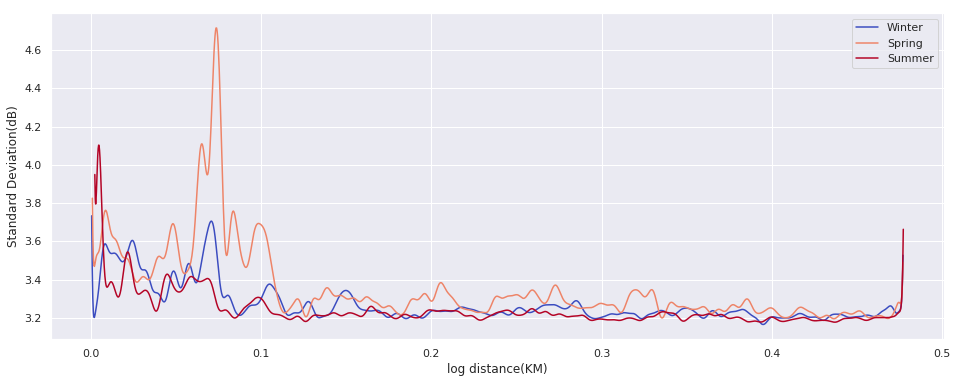

In [47]:
%autoreload
model = pickle.load(open('model/gp_'+kernel+'.sav', 'rb'))

data = makeXforGraphWithGroupingSeason(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=[yCols]))

graphX = data[0]
graphY = data[1]
train_2d_sigma_graph(model, graphX, graphY)